# Neighbourhood insights for buying a home in Edinburgh

## Table of Contents  
- [Introduction](#introduction)
- [Business problem](#introduction.business_problem)
    - [Static classification system](#introduction.static_classification_system)
    - [Dynamic ranking system](#introduction.dynamic_ranking_system)
- [Data](#data)
    - [Overview](#data.overview)
    - [Postcode data](#data.postcode_data)
    - [Define neighbourhoods](#data.define_neighbourhoods)
    - [Foursquare venue data](#data.foursquare_venue_data)
    - [Rightmove property sale price data](#data.rightmove_property_sale_price_data)
- [Methods](#methods)
    - [Neighbourhood size](#methods.neighbourhood_size)
    - [Normalizing distributions](#methods.normalizing_distributions)
    - [Static classification system](#methods.static_classification_system)
    - [Dynamic ranking system](#methods.dynamic_ranking_system)
    - [Analysis functions](#methods.analysis_functions)
- [Analysis](#analysis)
    - [Neighbourhood size](#analysis.neighbourhood_size)
    - [Normalizing distributions](#analysis.normalizing_distributions)

## Introduction <a name="introduction"/>

### Business problem <a name="introduction.business_problem"/>

A major estate agent in **Edinburgh** would like to provide more information about neighbourhoods to their clients. Local amenities are very important in deciding to buy a home, in addition to the property itself. This information, however, is not provided by the estate agent to the same quality as details about the property itself. **Presenting valuable insights about local amenities to potential buyers could attract more customers,** particularly those new to the city.

The insights about local amenities should be provided to the home buyer in a format that can be directly used in making their decision. Firstly, the information should be easy and quick to understand. Secondly, it should allow intuitive comparison between available properties. Thirdly, it should be objective truth, based on statistics, and not a biased opinion.

**This project aims to provide a solution for informing home buyers about the neighbourhoods in Edinburgh.** We will achieve this by generating two descriptive systems. Firstly, **a static classification system** for common preference types, such as favouring nightlife venues over parks or grocery stores over restaurants. Secondly, **a dynamic ranking system** that provides a ranking of neighbourhoods based on the client's personal preferences and purchase price range.

### Static classification system <a name="introduction.static_classification_system"/>

The static classification system will be created using **k-means clustering** of neighbourhoods based on the local amenities and identifying preference categories in the resulting clusters.

### Dynamic ranking system <a name="introduction.dynamic_ranking_system"/>

The dynamic ranking system will be ranking how well each neighbourhood matches the ideal neighbourhood based on user preferences. User input will be quantified relative to the **distribution of each feature across all neighbourhoods**. 

## Data <a name="data"/>

### Overview <a name="data.overview"/>

For this project we will need data on venues and amenities across Edinburgh and property sale price data. We will acquire the data on venues and amenities using Foursqare API. The sale price data will be acquired using web scraping on Rightmove website.

The neighbourhoods will be defined by their centers that are uniformly distributed positions across Edinburgh. Data listing venues of different categories and residential property sale prices will be collected and their distance to each of the neighbourhood centers will be computed. This will provide quick retrieval of nearby venues and property prices for neighbourhoods, whilst allowing for variable neighbourhood sizes.

These neighbourhoods with the resulting venue densities and property prices will be the subject of the statistical and machine learning methods.

### Postcode data <a name="data.postcode_data"/>

Acquire Edinburgh postcode data from doogal.co.uk

Download and load Edinburgh Postcode table that contains latitude and longitude

In [1]:
import pandas as pd
import os

if not os.path.isfile('EdinburghPostcodes.csv'):
    # If the file is not available on disk, download it
    urlretrieve ('https://www.doogal.co.uk/AdministrativeAreasCSV.ashx?district=S12000036', 'EdinburghPostcodes.csv')
df_postcodes = pd.read_csv('EdinburghPostcodes.csv', usecols=['Postcode', 'Latitude', 'Longitude', 'In Use?'])
# Only keep postcodes that are in use
df_postcodes.drop(df_postcodes[df_postcodes['In Use?'] == 'No'].index, inplace=True)
df_postcodes.drop(columns=['In Use?'], inplace=True)
df_postcodes.reset_index(drop=True, inplace=True)
# Make column names lower caps
df_postcodes.columns = map(str.lower, df_postcodes.columns)
# Display DataFrame
print('DataFrame shape: ', df_postcodes.shape)
df_postcodes.head()

DataFrame shape:  (13104, 3)


,postcode,latitude,longitude
0,EH1 1AD,55.948894,-3.192590
1,EH1 1AE,55.949033,-3.189375
2,EH1 1BB,55.952014,-3.189547
3,EH1 1BE,55.951961,-3.189944
4,EH1 1BL,55.950650,-3.191729


### Define neighbourhoods <a name="data.define_neighbourhoods"/>

We will define uniformly distributed points across Edinburgh to serve as centers for neighbourhoods. We will also find the postcode closest to the center of each neighbourhood. These postcodes are later used to identify each neighbourhood.

These neighbourhood center coordinates and their most proximal postcodes are then used to collect data specific to each location. This will allow later analysis of spatial distributions of venues and home prices.

Neighbourhood spacing is used as search radius for venue and property price data. This ensures the whole Edinburgh area of interest is fully covered. Any duplicates of venues and property prices are discarded. The actual radius of neighbourhoods can later be defined dynamically.

Define points on a rectangular grid with 250 m spacing in 4 km radius of Edinburgh Castle.

In [2]:
import geopy.distance
import numpy as np
import folium

neighbourhood_spacing = 250 # in meters
max_distance = 4000 # in meters

# Define central latitude and longitude as the position of Edinburgh Castle
edinburgh_castle_postcode = 'EH1 2NG'
central_latitude = df_postcodes[df_postcodes.postcode == edinburgh_castle_postcode]['latitude'].values
central_longitude = df_postcodes[df_postcodes.postcode == edinburgh_castle_postcode]['longitude'].values

# Calculate the distance in meters between two points 0.1 latitude apart in Edinburgh
lat01_in_m = geopy.distance.distance((central_latitude, central_longitude), 
                                      (central_latitude + 0.1, central_longitude)).km * 1000
lon01_in_m = geopy.distance.distance((central_latitude, central_longitude), 
                                      (central_latitude, central_longitude + 0.1)).km * 1000
# Calculate distance in latitude and longitude for neighbourhood spacing
neigh_spacing_lat = (neighbourhood_spacing * 0.1) / lat01_in_m
neigh_spacing_lon = (neighbourhood_spacing * 0.1) / lon01_in_m
# Calculate maximum and minimum coordinates that will be in range of central coordinates
max_lat = central_latitude + ((max_distance * 0.1) / lat01_in_m)
min_lat = central_latitude - ((max_distance * 0.1) / lat01_in_m)
max_lon = central_longitude + ((max_distance * 0.1) / lon01_in_m)
min_lon = central_longitude - ((max_distance * 0.1) / lon01_in_m)

# Calculate possible latitude positions for all neighbourhoods
neigh_lats = np.arange(min_lat, max_lat, neigh_spacing_lat)
# Calculate possible longitude positions for all neighbourhoods
neigh_lons = np.arange(min_lon, max_lon, neigh_spacing_lon)

# Assign latitude and longitude values for each neighbourhood
# Only keep use positions within specified radius of central coordinates
neighbourhood_lat_lon = []
for lat in neigh_lats:
    for lon in neigh_lons:
        distance_from_center = geopy.distance.distance((central_latitude, central_longitude), 
                                                       (lat, lon)).km * 1000
        if distance_from_center <= max_distance:
            neighbourhood_lat_lon.append((lat, lon))
            
# Arrange neighbourhoods in a DataFrame
lat, lon = list(zip(*neighbourhood_lat_lon))
df_neighbourhoods = pd.DataFrame({'latitude': lat, 'longitude': lon})
# Display neighbourhood DataFrame
print('DataFrame shape: ', df_neighbourhoods.shape)
df_neighbourhoods.head()

DataFrame shape:  (794, 2)


,latitude,longitude
0,55.913040,-3.201478
1,55.915285,-3.221486
2,55.915285,-3.217484
3,55.915285,-3.213483
4,55.915285,-3.209481


Assign a postcode closest to the center to each of the neighbourhoods.

In [3]:
if os.path.isfile('NeighbourhoodsWithPostcodes.p'):
    # If the script has already been run, load the result from disk
    df_neighbourhoods = pd.read_pickle('NeighbourhoodsWithPostcodes.p')
else:
    # Find closest postcode to the center of each neighbourhood
    postcodes = []
    for coords in zip(df_neighbourhoods['latitude'], df_neighbourhoods['longitude']):
        distances = []
        for pc_coords in zip(df_postcodes['latitude'], df_postcodes['longitude']):
            distances.append(geopy.distance.distance(coords, pc_coords).km)
        postcodes.append(df_postcodes.loc[np.argmin(distances), 'postcode'])
    # Append postcode list to the neighbourhoods DataFrame
    df_neighbourhoods['postcode'] = postcodes
    # Drop neighbourhoods where assigned postcode more than half the neighourhood spacing away from center
    distances = []
    for lat, lon, postcode in zip(df_neighbourhoods['latitude'], df_neighbourhoods['longitude'], df_neighbourhoods['postcode']):
        # Find the coordinates for the postcode
        pc_lat = float(df_postcodes.loc[df_postcodes['postcode'] == postcode, 'latitude'])
        pc_lon = float(df_postcodes.loc[df_postcodes['postcode'] == postcode, 'longitude'])
        distances.append(geopy.distance.distance((lat, lon), (pc_lat, pc_lon)).km * 1000)
    df_neighbourhoods.drop(df_neighbourhoods[np.array(distances) > neighbourhood_spacing / 2.0].index, inplace=True)
    # Reset index
    df_neighbourhoods.reset_index(drop=True, inplace=True)
    # Store resulting DataFrame on disk
    df_neighbourhoods.to_pickle('NeighbourhoodsWithPostcodes.p')
# Display resulting DataFrame
print('DataFrame shape: ', df_neighbourhoods.shape)
df_neighbourhoods.head()

DataFrame shape:  (664, 3)


,latitude,longitude,postcode
0,55.915285,-3.221486,EH10 5RT
1,55.915285,-3.217484,EH10 5SS
2,55.915285,-3.213483,EH10 6HA
3,55.915285,-3.209481,EH10 6JP
4,55.915285,-3.205480,EH10 6JX


Display neighbourhood positions with their central postcodes on a map.

In [4]:
m = folium.Map(location=[float(central_latitude), float(central_longitude)], zoom_start=12)
for lat, lon, postcode in zip(df_neighbourhoods['latitude'], df_neighbourhoods['longitude'], df_neighbourhoods['postcode']):
    # Draw a circle around the center of a neighbourhood with radius of neighbourhood spacing
    folium.Circle(
       location=(lat, lon),
       radius=neighbourhood_spacing,
       color='crimson', 
       weight=1, 
    ).add_to(m)
    # Find the coordinates for the postcode
    pc_lat = float(df_postcodes.loc[df_postcodes['postcode'] == postcode, 'latitude'])
    pc_lon = float(df_postcodes.loc[df_postcodes['postcode'] == postcode, 'longitude'])
    # Draw small blue circles at postcode locations
    folium.Circle(
       location=(pc_lat, pc_lon),
       radius=10,
       color='blue', 
       weight=2, 
    ).add_to(m)
#     # Add a popup to get Postcode
#     folium.Marker([pc_lat, pc_lon], popup='<i>{}</i>'.format(postcode)).add_to(m)
m

### Foursquare venue data <a name="data.foursquare_venue_data"/>

We will collect identity and coordinates for all venues close to each neighbourhood center for the following venue categories:
* Arts & Entertainment
* Event
* Food (restaurants)
* Cafe
* Nightlife Spot
* Outdoors & Recreation
* Athletics & Sports
* Spiritual Center
* Convenience Store
* Department Store
* Food & Drink Shop
* Bus Stop

We will also calculate the distance between each venue and neighbourhood centers.

Set Foursquare API key values.

In [5]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Define a function to obtain venues of specific category at specific location.

In [6]:
from requests import get


FOURSQUARE_CATEGORYIDS = {
    'Arts & Entertainment': '4d4b7104d754a06370d81259', 
    'Event': '4d4b7105d754a06373d81259', 
    'Food': '4d4b7105d754a06374d81259', 
    'Cafe': '4bf58dd8d48988d16d941735', 
    'Nightlife Spot': '4d4b7105d754a06376d81259', 
    'Outdoors & Recreation': '4d4b7105d754a06377d81259', 
    'Athletics & Sports': '4f4528bc4b90abdf24c9de85', 
    'Spiritual Center': '4bf58dd8d48988d131941735', 
    'Convenience Store': '4d954b0ea243a5684a65b473', 
    'Department Store': '4bf58dd8d48988d1f6941735', 
    'Food & Drink Shop': '4bf58dd8d48988d1f9941735', 
    'Bus Stop': '52f2ab2ebcbc57f1066b8b4f'}


def foursquare_categoryId(category):
    return FOURSQUARE_CATEGORYIDS[category]


def get_nearby_venues(latitude, longitude, category, radius):
    limit = 50 # Maximum allowed matches per Foursquare query
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?' + \
          'categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
              foursquare_categoryId(category), 
              CLIENT_ID, 
              CLIENT_SECRET, 
              VERSION, 
              latitude, 
              longitude, 
              radius, 
              limit)
            
    # Make the GET request
    results = get(url).json()
    
    # Check that at least one venue was found
    if isinstance(results, dict):
        if 'response' in results:
            if 'venues' in results['response']:
                if isinstance(results['response']['venues'], list):
                    if len(results['response']['venues']) > 0:
                        got_venues = True
                    else:
                        got_venues = False
    
    if got_venues:
        # Return ID and coordinates of all venues in a DataFrame
        return pd.DataFrame({
            'id': [venue['id'] for venue in results['response']['venues']], 
            'latitude': [venue['location']['lat'] for venue in results['response']['venues']], 
            'longitude': [venue['location']['lng'] for venue in results['response']['venues']], 
            'category': [category for _ in results['response']['venues']]})
    else:
        # Return a DataFrame with no values if no venues were found
        return pd.DataFrame({'id': [], 'latitude': [], 'longitude': [], 'category': []})


Collect information from Foursquare for each category of interest at all the neighbourhoods

In [7]:
if not os.path.isfile('EdinburghVenuesRaw.p'):
    # Collect all responses from Foursqare into a DataFrame
    df_venues = pd.DataFrame({'id': [], 'latitude': [], 'longitude': [], 'category': []})
    for latitude, longitude, postcode in zip(df_neighbourhoods['latitude'], df_neighbourhoods['longitude'], df_neighbourhoods['postcode']):
        for category in FOURSQUARE_CATEGORYIDS:
            df_venues = df_venues.append(get_nearby_venues(latitude, longitude, category, neighbourhood_spacing))

    # Reindex DataFrame
    df_venues.reset_index(drop=True, inplace=True)

    # Remove duplicates
    df_venues.drop_duplicates(subset=['id'], keep='first', inplace=True)
    # Sort venue DataFrame by coordinates for clarity
    df_venues.sort_values(['latitude', 'longitude'], inplace=True)
    # Reindex DataFrame
    df_venues.reset_index(drop=True, inplace=True)

    # Save results to disk
    df_venues.to_pickle('EdinburghVenuesRaw.p')
else:
    df_venues = pd.read_pickle('EdinburghVenuesRaw.p')
# Display the venues DataFrame
print('DataFrame shape: ', df_venues.shape)
df_venues.head()

DataFrame shape:  (5085, 4)


,category,id,latitude,longitude
0,Outdoors & Recreation,4da1be3a0f578cfaa3b09218,55.914277,-3.211846
1,Food & Drink Shop,4d90eb4d9b3841bdf2a6445f,55.914324,-3.211782
2,Outdoors & Recreation,4c271dea5c5ca593d75147fe,55.914325,-3.211833
3,Nightlife Spot,4c5483dc5b83952174a3ce31,55.914327,-3.211847
4,Outdoors & Recreation,502f830be4b01a4fc1880be0,55.914329,-3.211903


Calculate between each neighbourhood and all venues for quick reference.

In [8]:
if not os.path.isfile('EdinburghVenuesDistances.p'):
    # Compute distances between each venue and each postcode
    venue_distances = {}
    for pc_lat, pc_lon, postcode in zip(df_neighbourhoods['latitude'], df_neighbourhoods['longitude'], df_neighbourhoods['postcode']):
        venue_distances[postcode] = []
        for v_lat, v_lon in zip(df_venues['latitude'], df_venues['longitude']):
            venue_distances[postcode].append(int(geopy.distance.distance((v_lat, v_lon), (pc_lat, pc_lon)).km * 1000))

    # Put venue distances to a DataFrame and store to disk
    df_venue_distances = pd.DataFrame(venue_distances)

    # Save results to disk
    df_venue_distances.to_pickle('EdinburghVenuesDistances.p')
else:
    df_venue_distances = pd.read_pickle('EdinburghVenuesDistances.p')
# Display the venue distances DataFrame
print('DataFrame shape: ', df_venue_distances.shape)
df_venue_distances.head()

DataFrame shape:  (5085, 664)


,EH1 1AE,EH1 1DF,EH1 1DH,EH1 1HD,EH1 1LY,EH1 1YZ,EH1 2BU,EH1 2EU,EH1 2HU,EH1 2NA,...,EH9 3BY,EH9 3DW,EH9 3EB,EH9 3ER,EH9 3HE,EH9 3HQ,EH9 3HT,EH9 3JA,EH9 3JE,EH9 3JT
0,4107,4343,4430,3873,4199,4269,3865,3882,3722,3965,...,2544,2549,2686,2138,1989,2200,1952,2337,2420,2644
1,4101,4337,4423,3867,4192,4263,3859,3877,3716,3959,...,2538,2544,2680,2132,1982,2194,1945,2330,2414,2638
2,4102,4338,4425,3868,4194,4264,3859,3877,3716,3959,...,2541,2547,2682,2134,1985,2197,1948,2333,2416,2641
3,4102,4338,4425,3868,4194,4264,3859,3877,3716,3959,...,2541,2548,2683,2135,1985,2198,1948,2333,2417,2642
4,4103,4339,4426,3869,4195,4264,3859,3877,3717,3960,...,2544,2551,2686,2137,1988,2201,1950,2336,2420,2645


Inspect the number of venues of each category per neighbourhood.

In [9]:
df_tmp = pd.DataFrame(df_venues['category'].value_counts())
df_tmp.rename(columns={'category': 'total'}, inplace=True)
df_tmp['per neighbourhood'] = pd.DataFrame(df_tmp['total'] / df_neighbourhoods.shape[0])
df_tmp

,total,per neighbourhood
Food,1659,2.498494
Outdoors & Recreation,750,1.129518
Nightlife Spot,710,1.069277
Arts & Entertainment,658,0.990964
Cafe,462,0.695783
Food & Drink Shop,297,0.447289
Bus Stop,290,0.436747
Spiritual Center,144,0.216867
Convenience Store,106,0.159639
Department Store,7,0.010542


As *Department Store* and *Event* venues are so rare in the dataset, we will remove them.

In [10]:
# Find indices of venues that are in either Department Store or Event cateogry
indices = df_venues[(df_venues['category'] == 'Department Store') | (df_venues['category'] == 'Event')].index
# Drop rows from df_venues
df_venues.drop(index=(indices), inplace=True)
df_venues.reset_index(drop=True, inplace=True)
# Drop rows from df_venue_distances
df_venue_distances.drop(index=(indices), inplace=True)
df_venue_distances.reset_index(drop=True, inplace=True)

Display the final Foursquare venue data

In [11]:
# Display the number of venues per category
df_tmp = pd.DataFrame(df_venues['category'].value_counts())
df_tmp.rename(columns={'category': 'total'}, inplace=True)
df_tmp['per neighbourhood'] = pd.DataFrame(df_tmp['total'] / df_neighbourhoods.shape[0])
df_tmp

,total,per neighbourhood
Food,1659,2.498494
Outdoors & Recreation,750,1.129518
Nightlife Spot,710,1.069277
Arts & Entertainment,658,0.990964
Cafe,462,0.695783
Food & Drink Shop,297,0.447289
Bus Stop,290,0.436747
Spiritual Center,144,0.216867
Convenience Store,106,0.159639


In [12]:
# Display the venues DataFrame
print('DataFrame shape: ', df_venues.shape)
df_venues.head()

DataFrame shape:  (5076, 4)


,category,id,latitude,longitude
0,Outdoors & Recreation,4da1be3a0f578cfaa3b09218,55.914277,-3.211846
1,Food & Drink Shop,4d90eb4d9b3841bdf2a6445f,55.914324,-3.211782
2,Outdoors & Recreation,4c271dea5c5ca593d75147fe,55.914325,-3.211833
3,Nightlife Spot,4c5483dc5b83952174a3ce31,55.914327,-3.211847
4,Outdoors & Recreation,502f830be4b01a4fc1880be0,55.914329,-3.211903


In [13]:
# Display the venue distances DataFrame
print('DataFrame shape: ', df_venue_distances.shape)
df_venue_distances.head()

DataFrame shape:  (5076, 664)


,EH1 1AE,EH1 1DF,EH1 1DH,EH1 1HD,EH1 1LY,EH1 1YZ,EH1 2BU,EH1 2EU,EH1 2HU,EH1 2NA,...,EH9 3BY,EH9 3DW,EH9 3EB,EH9 3ER,EH9 3HE,EH9 3HQ,EH9 3HT,EH9 3JA,EH9 3JE,EH9 3JT
0,4107,4343,4430,3873,4199,4269,3865,3882,3722,3965,...,2544,2549,2686,2138,1989,2200,1952,2337,2420,2644
1,4101,4337,4423,3867,4192,4263,3859,3877,3716,3959,...,2538,2544,2680,2132,1982,2194,1945,2330,2414,2638
2,4102,4338,4425,3868,4194,4264,3859,3877,3716,3959,...,2541,2547,2682,2134,1985,2197,1948,2333,2416,2641
3,4102,4338,4425,3868,4194,4264,3859,3877,3716,3959,...,2541,2548,2683,2135,1985,2198,1948,2333,2417,2642
4,4103,4339,4426,3869,4195,4264,3859,3877,3717,3960,...,2544,2551,2686,2137,1988,2201,1950,2336,2420,2645


### Rightmove property sale price data <a name="data.rightmove_property_sale_price_data"/>

Rightmove is a major UK property website. They provide a list of sale price data going back several years. 

For some of the properties on the list there is a link to a post on Rightmove website and information on the type of the property, including number of bedrooms. As the latter information is a major determinant of sale price, we will only use data on properties where this information is available. This will allow more client preference specific estimation of mean property prices in neighbourhoods.

Rightmove provides the address for each property, including the postcode. We will use a Edinburgh postcode latitude and longitude dataset to approximate the latitude and longitude of each property. This will allow be used to compute the distance of each property to each neighbourhood center.

In [14]:
from urllib.request import urlretrieve
from bs4 import BeautifulSoup
import sys

Define function the extract data for properties from a BeautifulSoup of a html webpage

In [15]:
def get_property_type_from_sold_property_page(url):
    soup = BeautifulSoup(get(url).text, 'html.parser')
    return soup.find(id='propertydetails').find_all('h2')[1].text


def get_property_data_from_soup(soup):
    # Extract data from the http soup
    date = []
    address = []
    bedrooms = []
    price = []
    property_type = []
    for soup_property in soup.find_all(class_='soldDetails'):
        # Skip properties for which there is no link to post on RightMove website
        if not soup_property.find(class_='soldAddress').has_attr('href'):
            continue
        else:
            url = soup_property.find(class_='soldAddress')['href']
        # Skip properties for which there is no number of bedrooms information
        if len(soup_property.find(class_='noBed').text) == 0:
            continue
        # Collect data for the property
        date.append(soup_property.find(class_='soldDate').text)
        address.append(soup_property.find(class_='soldAddress').text)
        bedrooms.append(soup_property.find(class_='noBed').text)
        price.append(soup_property.find(class_='soldPrice').text)
        # Attempt to collect property type
        try:
            property_type.append(get_property_type_from_sold_property_page(url))        
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            property_type.append('')
            print('Error when collecting property type.')
            print(sys.exc_info()[0])
    # Format data into pandas.DataFrame
    df = pd.DataFrame({'date': date, 
                       'address': address, 
                       'bedrooms': bedrooms, 
                       'property_type': property_type, 
                       'price': price}, 
                      columns=['date', 'address', 'bedrooms', 'property_type', 'price'])
    # Sort the DataFrame by date as well as address
    df.sort_values(['date', 'address'], ascending=[False, True], inplace=True)
    
    return df

Create a class to manage web scraping rate

In [16]:
from time import time, sleep

class RateManager(object):
    
    def __init__(self, min_interval, max_interval):
        """
        min_interval - float - minimum delay between calls (in seconds)
        max_interval - float - maximum delay between calls before notification (in seconds)
        """
        self.min_interval = min_interval
        self.max_interval = max_interval
        self.checkpoint = None
        
    def continue_when_ready(self, sleep_interval=0.1, print_interval=False):
        # This is in case of first call to continue_when_ready
        if self.checkpoint is None:
            self.checkpoint = time()
            return None
        # Check if max_interval has been surpassed
        if time() - self.checkpoint > self.max_interval:
            if print_interval:
                print('Interval duration: {}'.format(time() - self.checkpoint))
            self.checkpoint = time()
            return 'timeout'
        # If not over max_interval, wait until min_interval is reached
        if print_interval:
            print('Interval duration: {}'.format(time() - self.checkpoint))
        while time() - self.checkpoint < self.min_interval:
            sleep(sleep_interval)
        self.checkpoint = time()
        return 'intime'


Create a function to construct rightmove.co.uk URL for specific house price search

In [17]:
from selenium import webdriver

def rightmove_houseprice_bypostcode_url(radius=250, years=2):
    """
    Return URL to webpage that allows searching for property sale prices
    nearby a specific postcode. The postcode must be specified in a text box
    on the website to get access to the postcode specific data. This URL
    only specifies the radius and years of history parameters of the search.
    """
    # Ensure input arguments are allowed
    if radius == 250:
        radius = '0.25'
    elif radius == 500:
        radius = '0.5'
    else:
        raise ValueError('No http address key set for radius {}'.format(radius))
    if not isinstance(years, int) or years > 6 or years < 1:
        raise ValueError('years argument must be int in range 1 to 6.')
    url = 'https://www.rightmove.co.uk/house-prices/detail.html?' + \
          'country=scotland&locationIdentifier=POSTCODE%5E1071308' + \
          '&searchLocation=EH1+2NG&propertyType=3&radius={}&year={}'.format(radius, years) + \
          '&referrer=listChangeCriteria'
    
    return url


def append_specify_page_index_to_houseprice_url(url, page_nr):
    # Ensure input arguments are allowed
    if page_nr > 40:
        raise ValueError('page_nr argument not allowed over 40.')
    # Append page index key value
    url = url + '&index={}'.format(page_nr * 25)
    
    return url


def rightmove_houseprice_url(postcode, radius=250, years=2):
    """
    Opens the rightmove.co.uk URL for houseprice search and
    enters a postcode to get URL for the page listing property
    sale prices for that specific postcode.
    """
    # Get URL to the search page with already specified radius and year parameters
    url = rightmove_houseprice_bypostcode_url(radius=radius, years=years)
    # Open Chrome headless browser driver with minimal parameters
    options = webdriver.chrome.options.Options()
    options.add_argument('headless')
    options.add_argument('window-size=1200x600')
    chrome_prefs = {}
    options.experimental_options["prefs"] = chrome_prefs
    chrome_prefs["profile.default_content_settings"] = {"images": 2}
    chrome_prefs["profile.managed_default_content_settings"] = {"images": 2}
    driver = webdriver.Chrome(options=options)
    # Open the webpage
    driver.get(url)
    # Enter postcode and click search
    driver.find_element_by_id('searchLocation').clear()
    driver.find_element_by_id('searchLocation').send_keys(postcode)
    driver.find_element_by_id('housePrices').click()
    # Retrieve the URL of the newly accessed webpage
    url = driver.current_url
    # Close the Chrome browser driver
    driver.quit()
    
    return url

Acquire residential property sales prices from RightMove for Edinburgh areas of interest going back 2 years.

There are likely duplicates in the resulting DataFrame. These will be dealt with later.

In [18]:
if os.path.isfile('EdinburghPropertiesRaw.p'):
    # If the script has already been run, load the result from disk
    df_property = pd.read_pickle('EdinburghPropertiesRaw.p')
else:
    # Create empty pandas.DataFrame to append new data to
    df_property = pd.DataFrame({'date': [], 
                                'address': [], 
                                'bedrooms': [], 
                                'property_type': [], 
                                'price': [], 
                                'search_postcode': []}, 
                               columns=['date', 
                                        'address', 
                                        'bedrooms', 
                                        'property_type', 
                                        'price', 
                                        'search_postcode'])

    # Use RateManager to avoid overwhelming the website
    rate_manager = RateManager(min_interval=5, max_interval=30)
    max_timeouts = 10
    timeout_count = 0

    # Loop through all postcodes and all possible page indices
    df_prev_property_list = pd.DataFrame({})
    for i, postcode in enumerate(df_neighbourhoods['postcode']):
        print('--------Getting price data for postcode {} --- {} of {} ---'.format(postcode, i + 1, len(df_neighbourhoods['postcode'])))
        url = None
        while url is None:
            # Get URL for the webpage listing house price data for this postcode
            try:
                url = rightmove_houseprice_url(postcode, radius=(neighbourhood_spacing), years=2)
            except (KeyboardInterrupt, SystemExit):
                raise
            except:
                print('Failed to get url. Trying again in 1 minute.')
                sleep(60)
        for page_nr in range(40):
            full_url = append_specify_page_index_to_houseprice_url(url, page_nr)
            print('Visiting webpage:\n' + full_url)
            # Make sure webpage is not visited too often and that it is not blocking
            if rate_manager.continue_when_ready(print_interval=True) == 'timeout':
                timeout_count += 1
                if timeout_count > max_timeouts:
                    raise RuntimeError('Too many timeouts.')
            # Get website html as BeautifulSoup
            soup = BeautifulSoup(get(full_url).text, 'html.parser')
            # Check if there is a property price data list on this page
            if len(soup.find_all(class_='soldDetails')) == 0:
                print('No properties listed on this page. Stopping page index iteration.')
                break
            df_next_property_list = get_property_data_from_soup(soup)
            # If the new DataFrame is equal to the previous one, stop checking further indices
            if df_prev_property_list.equals(df_next_property_list):
                print('Property list repeated. Stopping page index iteration.')
                break
            else:
                # Append the new property list to main property list and store to check against next one
                df_prev_property_list = df_next_property_list
                print('Got {} properties.'.format(df_next_property_list.shape[0]))
                df_next_property_list['search_postcode'] = postcode
                df_property = df_property.append(df_next_property_list)
        # Save collected property data to disk
        df_property.to_pickle('EdinburghPropertiesRaw.p')
# Report number of properties in raw web scarping result
print('Collected total of {} properties from RightMove.'.format(df_property.shape[0]))

Collected total of 39647 properties from RightMove.


Format `df_property` DataFrame and keep only the essential information

In [19]:
# Define function for extracting number of bedrooms and
# general property type from raw property type data
def get_bedrooms_and_type(raw_property_type):
    pos = raw_property_type.find(' bedroom ')
    raw_property_type = raw_property_type.replace(' bedroom ', ' ')
    bedrooms = raw_property_type[:pos].strip()
    property_type = raw_property_type[pos:].strip()
    
    return bedrooms, property_type


# Reindex DataFrame
df_property.reset_index(drop=True, inplace=True)

# Remove duplicates
df_property.drop_duplicates(subset=['date', 'address', 'price'], keep='first', inplace=True)
# Reindex DataFrame
df_property.reset_index(drop=True, inplace=True)

# Find property_type 'Studio flat' and set it to 1 bedroom flat
idx_studio_flat = df_property['property_type'] == 'Studio flat'
df_property['property_type'].loc[idx_studio_flat] = '1 bedroom flat'

# Remove properties for which property_type is not in correct format
indices = [i for i, x in enumerate(df_property['property_type']) if not (' bedroom ' in x)]
df_property.drop(indices, axis=0, inplace=True)
# Reindex DataFrame
df_property.reset_index(drop=True, inplace=True)

# Extract number of bedrooms and general property type from property_type values
bedrooms, property_type = zip(*[get_bedrooms_and_type(x) for x in df_property['property_type']])
df_property['bedrooms'] = list(map(int, bedrooms))
df_property['property_type'] = property_type

# Rename all flat-like property_types to flats
func = lambda x: 'flat' if 'flat' in x or 'apartment' in x or 'penthouse' in x else x
df_property['property_type'] = df_property['property_type'].apply(func)
# Rename all house-like property_types to house
func = lambda x: 'house' if 'house' in x or 'villa' in x or 'duplex' in x or 'bungalow' in x or 'cottage' in x else x
df_property['property_type'] = df_property['property_type'].apply(func)

# Remove all other property_types than flat or house
idx = (df_property['property_type'] != 'flat') & (df_property['property_type'] != 'house')
df_property.drop(df_property[idx].index, axis=0, inplace=True)
# Reindex DataFrame
df_property.reset_index(drop=True, inplace=True)

# Only keep postcode from address
func = lambda x: ' '.join(x.split()[-2:])
df_property['address'] = df_property['address'].apply(func)
# Rename address column to postcode
df_property.rename(columns={'address': 'postcode'}, inplace=True)

# Convert price from string to integer
func = lambda x: int(x[1:].replace(',', ''))
df_property['price'] = df_property['price'].apply(func)

# Print remaining number of properties
print('Property sale price samples remaining after filtering the data: {}'.format(df_property.shape[0]))

Property sale price samples remaining after filtering the data: 5460


Add longitude and latitude data into `df_property` based on postcode

In [20]:
# Merge on latitude and longitude values
df_property = df_property.merge(df_postcodes, how='left', on='postcode')
# Drop rows where latitude and longitude were not available for postcode
df_property.dropna(inplace=True)
# Reindex DataFrame
df_property.reset_index(drop=True, inplace=True)
# # Drop postcode column
# df_property.drop('postcode', axis='columns', inplace=True)
print('Property sale price samples remaining that have \n' + 
      'latitude and logitude values: {}'.format(df_property.shape[0]))
print('DataFrame shape: ', df_property.shape)
df_property.head()

Property sale price samples remaining that have 
latitude and logitude values: 5460
DataFrame shape:  (5460, 8)


,date,postcode,bedrooms,property_type,price,search_postcode,latitude,longitude
0,28 Jan 2019,EH13 9ET,2,flat,120000,EH10 5RT,55.912698,-3.224450
1,27 Nov 2018,EH10 5XB,2,flat,330000,EH10 5RT,55.917900,-3.225414
2,27 Aug 2018,EH10 5TH,3,flat,400000,EH10 5RT,55.916122,-3.227070
3,24 Sep 2018,EH10 5XD,2,flat,380000,EH10 5RT,55.917065,-3.224476
4,24 Dec 2018,EH10 5SJ,4,house,610000,EH10 5RT,55.917254,-3.219873


Display the proportion of proprties of different types and their mean prices.

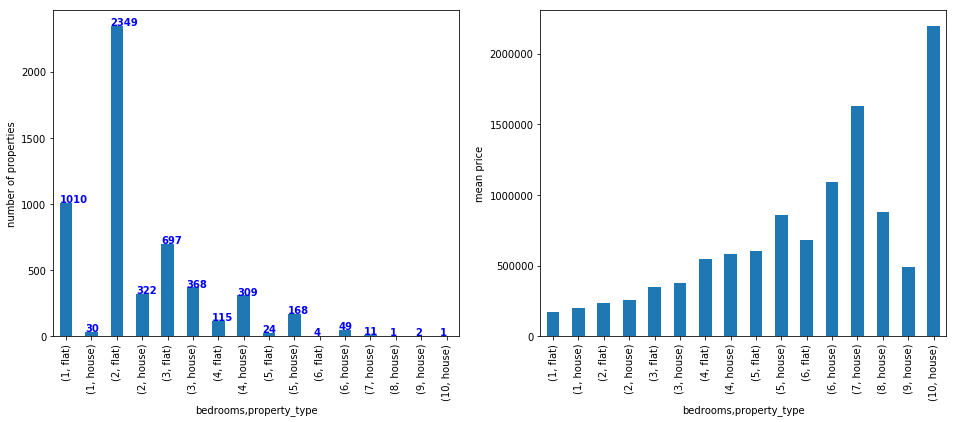

In [92]:
# Create the figure
fig = plt.figure(figsize=(16, 6))
axs = fig.subplots(1, 2)
# Plot property counts
property_counts = df_property.groupby(['bedrooms', 'property_type'])['property_type'].count()
_ = property_counts.plot(kind='bar', ax=axs[0])
axs[0].set_ylabel('number of properties')
axs[1].set_ylabel('mean price')
for i, v in enumerate(property_counts):
    axs[0].text(i - 0.25, v + 3, str(v), color='blue', fontweight='bold')
# Plot property mean prices
_ = df_property.groupby(['bedrooms', 'property_type'])['price'].mean().plot(kind='bar', ax=axs[1])

By far the most commonly sold property type is 2 bedroom flat. The next property types in decreasing order of sales are 1 bedroom flat, 3 bedroom flat, 3 bedroom house, 2 bedroom house and 4 bedroom house. Properties with more than 5 bedrooms are very rare in the dataset. The number of flats sold compared to houses is much higher for 1, 2 and 3 bedroom properties, while it is the other way round for properties with more bedrooms.

The mean price of flats and houses with same number of bedrooms is roughly the same. This suggests that to maximise samples of sale prices in each neighbourhood, the prices of flats and houses could be combined.

Calculate distances between each neighbourhood and all properties for quick reference later.

In [21]:
if not os.path.isfile('EdinburghPropertiesDistances.p'):
    # Compute distances between each venue and each postcode
    property_distances = {}
    for pc_lat, pc_lon, postcode in zip(df_neighbourhoods['latitude'], df_neighbourhoods['longitude'], df_neighbourhoods['postcode']):
        property_distances[postcode] = []
        for p_lat, p_lon in zip(df_property['latitude'], df_property['longitude']):
            property_distances[postcode].append(int(geopy.distance.distance((p_lat, p_lon), (pc_lat, pc_lon)).km * 1000))

    # Put venue distances to a DataFrame and store to disk
    df_property_distances = pd.DataFrame(property_distances)

    # Save results to disk
    df_property_distances.to_pickle('EdinburghPropertiesDistances.p')
else:
    df_property_distances = pd.read_pickle('EdinburghPropertiesDistances.p')
# Display the venues DataFrame
print('DataFrame shape: ', df_property_distances.shape)
df_property_distances.head()

DataFrame shape:  (5460, 664)


,EH1 1AE,EH1 1DF,EH1 1DH,EH1 1HD,EH1 1LY,EH1 1YZ,EH1 2BU,EH1 2EU,EH1 2HU,EH1 2NA,...,EH9 3BY,EH9 3DW,EH9 3EB,EH9 3ER,EH9 3HE,EH9 3HQ,EH9 3HT,EH9 3JA,EH9 3JE,EH9 3JT
0,4591,4813,4931,4373,4716,4704,4144,4208,4146,4375,...,3315,3352,3438,2881,2756,2980,2673,3096,3207,3438
1,4124,4335,4470,3916,4265,4211,3599,3676,3653,3874,...,3147,3280,3231,2674,2595,2837,2442,2909,3080,3324
2,4346,4558,4692,4138,4486,4435,3818,3897,3876,4097,...,3309,3415,3405,2846,2754,2991,2619,3076,3231,3471
3,4171,4386,4516,3960,4307,4267,3673,3744,3708,3932,...,3121,3236,3214,2655,2567,2805,2427,2887,3046,3288
4,4009,4231,4349,3791,4133,4125,3589,3643,3566,3798,...,2844,2949,2944,2384,2288,2524,2162,2612,2763,3004


## Methods <a name="methods"/>

To serve the aim of this project "to provide a solution for informing home buyers about the neighbourhoods in Edinburgh", we will be performing two descriptive analyses. Firstly, classifying each neighbourhood based on the number of nearby venues in each category. Secondly, providing a ranking system that can be tailored to anyones personal preference.

The neighbourhoods have been defined arbitarily and are overlapping. This to allow describing properties of different areas in Edinburgh based purely on geometric separation and not municipalities or other human defined regions. Therefore, the results are presented as heatmaps across Edinburgh, identifying areas of different category or ranking.

### Neighbourhood size<a name="methods.neighbourhood_size"/>

The [Analysis](#analysis) section will cover data exploration to decide on the radius of neighourhoods to use. The size of the neighbourhoods needs to be large enough to be representative of local venue distributions, but small enough to give local information.

### Normalizing distributions<a name="methods.normalizing_distributions"/>

All data used for static classification or the dynamic ranking system will be normalized with z-score method. This is to ensure features with larger absolute values like number of cafes or property prises will not be the sole determinants of classification of ranking.

### Static classification system <a name="methods.static_classification_system"/>

The count of venues in each category local to each neighbourhood will be obtained. This will result in numerical data than can be easily clustered using most clustering methods. We will ignore the property price data in the static classification system.

We will use k-means clustering as the numerical form of data permits using this simple and intuitive method. We will experiment with a few different K values and make a subjective decision to pick one of the results for the static classification system. We will assign descriptive category names based on the relative occurance of each venue category.

### Dynamic ranking system <a name="methods.dynamic_ranking_system"/>

The dynamic ranking system is not a stand-alone analysis, but a convenient tool for anyone to find neighbourhoods matching their preferences. The user can adjust any parameter to their liking and see on the map which areas best fit their criteria.

Similarly to the static classification system, we will use the count of venues in each category local to each neighbourhood. Additionally, we will be including the mean price of properties of each type in each neighbourhood.

The ranking is based on euclidean distance between the ideal values set by the user and those of each of the neighbourhoods.

### Analysis functions <a name="methods.analysis_functions"/>

In this section we will define the functions reused across the analysis, in both the classification and ranking systems.

Define function to find the number of venues at specific distance from each neighbourhood

In [22]:
def number_of_venues_in_area(radius, df_venue_distances, neighbourhood_postcode, 
                             df_venues, venue_categories=[]):
    """
    Returns a pandas.DataFrame with number of venues in each category within specified
    radius of the neighbourhood center.
    
    venue_categories - optional list - allows specifying which categories to include
    """
    # If venue_categoreis not provided, use all in venue list
    if len(venue_categories) == 0:
        venue_categories = list(df_venues['category'].unique())
    # Loop through each category
    count = {}
    for category in venue_categories:
        # Find total number of venues in the cateogry and in specified radius of neighbourhood center
        in_category = df_venues['category'] == category
        in_area = df_venue_distances[neighbourhood_postcode] < radius
        count[category] = [sum(in_category & in_area)]
        
    return pd.DataFrame(count, columns=venue_categories)


def number_of_venues_in_all_areas(radius, df_venues, df_venue_distances, df_neighbourhoods, 
                                  venue_categories=[]):
    """
    Returns a pandas.DataFrame with number of venues in each category within
    specified radius of each neighbourhood center.
    
    venue_categories - optional list - allows specifying which categories to include
    """
    # If venue_categoreis not provided, use all in venue list
    if len(venue_categories) == 0:
        venue_categories = list(df_venues['category'].unique())
    # Loop through all neighbourhoods
    df = pd.DataFrame({category: [] for category in venue_categories}, columns=venue_categories)
    for postcode in df_neighbourhoods['postcode']:
        df = df.append(number_of_venues_in_area(
                           radius, df_venue_distances, postcode, 
                           df_venues, venue_categories=venue_categories))
    # Reindex DataFrame
    df.reset_index(drop=True, inplace=True)
    
    return df


Define function to calculate mean property prices at specific distance from each neighbourhood

In [23]:
def mean_price_in_area(radius, df_property_distances, neighbourhood_postcode, 
                       df_property, bedrooms=[], property_type=[], min_count=1):
    """
    Returns the mean price for properties of specific size and type.
    
    bedrooms - optional list - allows limiting count to properties with specific number of beds
    property_type - optional list - allows limiting count to properties of specific type
    """
    # If n_bedrooms not provided, use all in n_bedrooms list
    if len(bedrooms) == 0:
        bedrooms = list(df_property['bedrooms'].unique())
    # If n_bedrooms not provided, use all in n_bedrooms list
    if len(property_type) == 0:
        property_type = list(df_property['property_type'].unique())
    # Find properties matching the number of bedrooms and property type criteria
    correct_bedrooms = df_property['bedrooms'].map(lambda x: x in bedrooms)
    correct_property_type = df_property['property_type'].map(lambda x: x in property_type)
    # Find properties in specified radius of neighbourhood center
    in_area = df_property_distances[neighbourhood_postcode] < radius
    # Compute the mean price for properties matching these criteria
    idx = correct_bedrooms & correct_property_type & in_area
    if sum(idx) >= min_count:
        price = df_property['price'][idx].mean()
    else:
        price = np.nan
        
    return price


def mean_price_in_all_areas(radius, df_property, df_property_distances, df_neighbourhoods, 
                            bedrooms=[], property_type=[], min_count=1):
    """
    Returns a list of mean prices for properties in each area matching the criteria if provided.
    
    bedrooms - optional list - allows limiting count to properties with specific number of beds
    property_type - optional list - allows limiting count to properties of specific type
    """
    # If n_bedrooms not provided, use all in n_bedrooms list
    if len(bedrooms) == 0:
        bedrooms = list(df_property['bedrooms'].unique())
    # If n_bedrooms not provided, use all in n_bedrooms list
    if len(property_type) == 0:
        property_type = list(df_property['property_type'].unique())
    # Loop through all neighbourhoods
    prices = []
    for postcode in df_neighbourhoods['postcode']:
        prices.append(mean_price_in_area(
                          radius, df_property_distances, postcode, 
                          df_property, bedrooms=bedrooms, property_type=property_type, 
                          min_count=min_count))
    
    return prices


Define functions for pre-processing features

In [24]:
from sklearn.preprocessing import StandardScaler


def zscore_dataframe(df):
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    scaler.fit(df)
    df = pd.DataFrame(scaler.transform(df), columns=df.columns)
    
    return df


def log_all_elements(df):
    return df.applymap(lambda x: np.log(x + 1))


def normalize(df, method):
    if 'log' in method:
        df = df.applymap(lambda x: np.log(x + 1))
    if 'zscore' in method:
        df = zscore_dataframe(df)
    return df


Define functions for plotting the distributions of features with variable ``radius``

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt


def plot_histogram(ax, data, label):
    data.plot(kind='hist', ax=ax, bins=20)
    ax.set_xlabel(label)


def plot_multiple_histograms(df, normalize_method=[]):
    if len(normalize_method) > 0:
        df = normalize(df, normalize_method)
    fig = plt.figure(figsize=(18, 8))
    axs = fig.subplots(1, df.shape[1], sharey=True)
    for label, ax in zip(df.columns, axs):
        plot_histogram(ax, df[label], label)


## Analysis <a name="analysis"/>



### Neighbourhood size<a name="analysis.neighbourhood_size"/>

To decide on the correct neighbourhood size to use, we first plot the distribution of venue counts across neighbourhoods by category for different values of neighbourhood ``radius``.

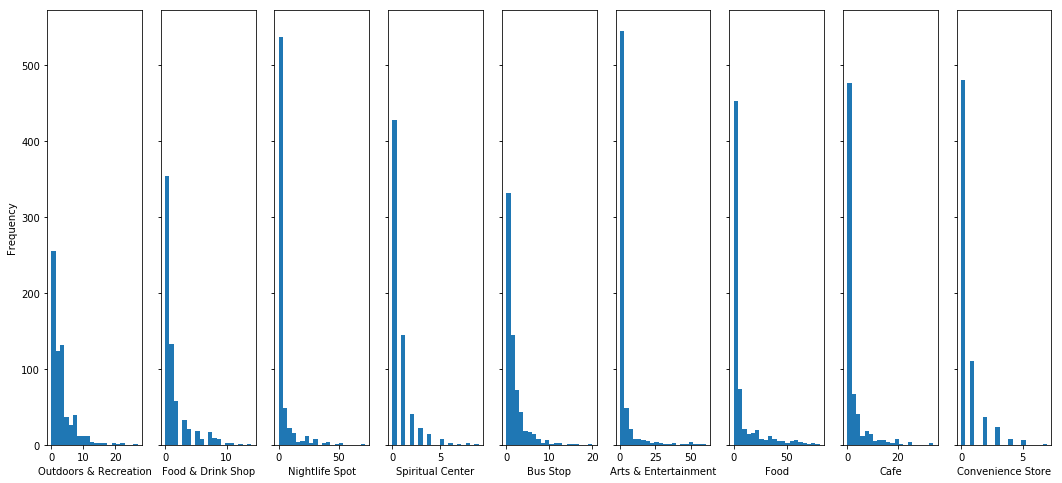

In [26]:
radius = 250
plot_multiple_histograms(number_of_venues_in_all_areas(radius, df_venues, df_venue_distances, df_neighbourhoods))

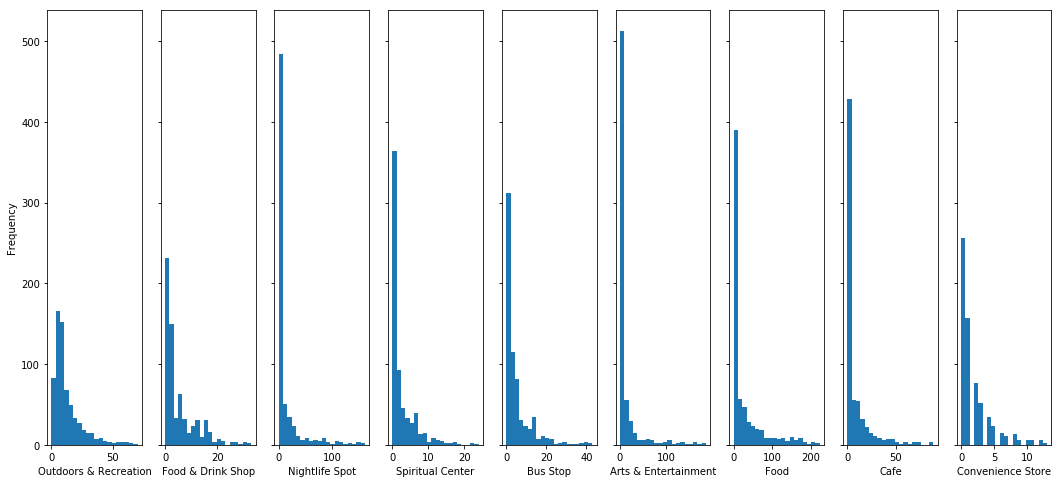

In [27]:
radius = 500
plot_multiple_histograms(number_of_venues_in_all_areas(radius, df_venues, df_venue_distances, df_neighbourhoods))

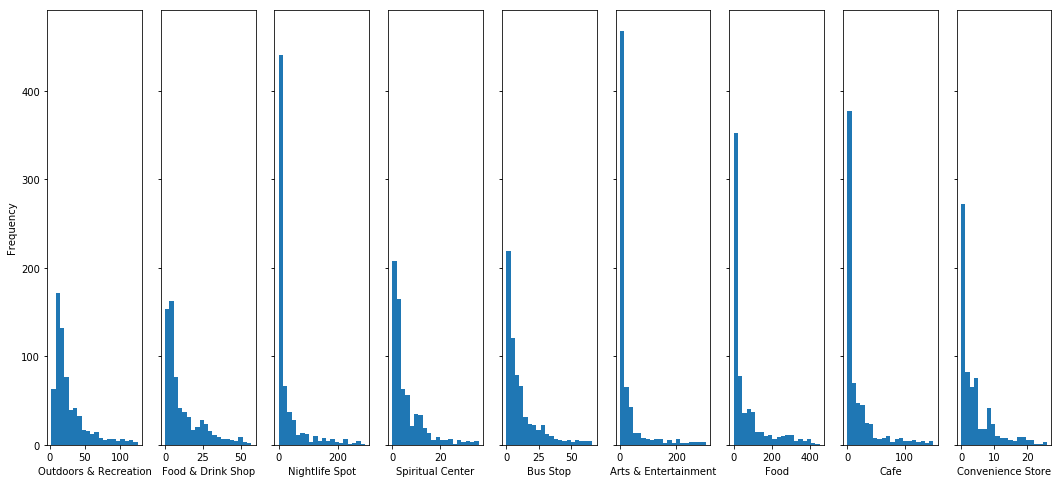

In [28]:
radius = 750
plot_multiple_histograms(number_of_venues_in_all_areas(radius, df_venues, df_venue_distances, df_neighbourhoods))

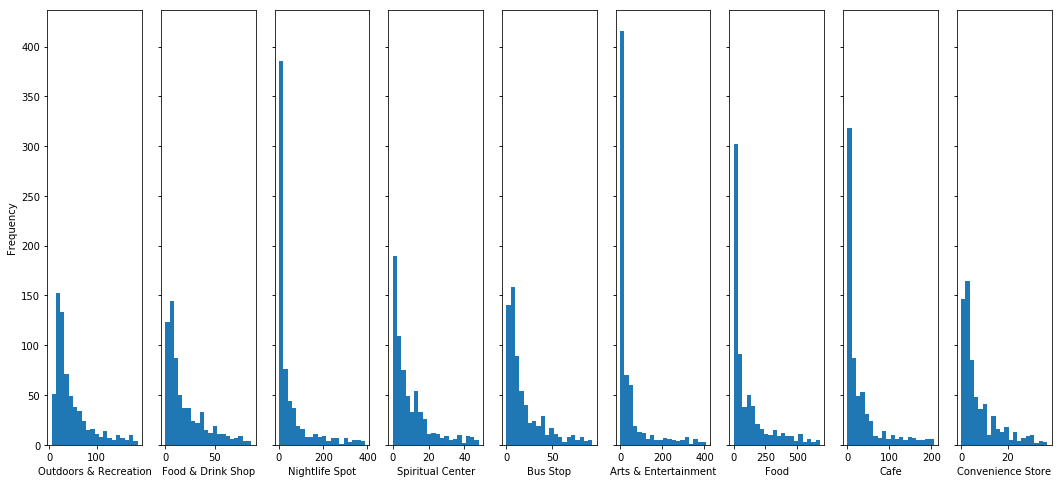

In [29]:
radius = 1000
plot_multiple_histograms(number_of_venues_in_all_areas(radius, df_venues, df_venue_distances, df_neighbourhoods))

In all venue categories, with radius of 250 m, there is a very high proportion of neighbourhoods with zero venues. With 500 m ``radius`` the distributions are a bit broader and proportion of neighbourhoods with at least 1 venue is much larger, particularly for *Outdoors & Recreation* and *Food & Drink Shop* categories. With 750 m and 1000 m ``radius`` the distributions are broad in most categories, but at this level the spatial accuracy of the information starts to decay.

To assess the impact of the ``radius`` parameter on estimating property prices, we can inspect the number of neighbourhoods with insufficient data if the ``radius`` is set too small.

Let's set a criteria that to get an acceptable estimate of property price for a specific criteria (location, number of bedrooms, flats or houses), we need to have at least 5 matches to the criteria for computing the mean price. 

The function ``mean_price_in_all_areas`` defined above returns the mean price of properties that match a given criteria for each neighbourhood. It allows computing this with different values of ``radius``. Furthermore, with ``min_count`` it is possible to set a lower limit for number of properties for which the mean value is calculated. If not enough properties match the criteria for a neighbourhood with a given ``radius``, then the output is an empty value, ``np.nan``. We can use this function with different criteria and ``radius`` and see how many neighbourhoods don't meet the criteria for computing the property price.

In [41]:
radii = [250, 500, 750, 1000]
# Calculate 2 bed property prices for different radius values and note how many included
prices = [mean_price_in_all_areas(radius, df_property, df_property_distances, df_neighbourhoods, 
                                  bedrooms=[2], min_count=5) 
          for radius in radii]
n_areas_included_2bed = [sum(~np.isnan(x)) for x in prices]
# Calculate 3 bed property prices for different radius values
prices = [mean_price_in_all_areas(radius, df_property, df_property_distances, df_neighbourhoods, 
                                  bedrooms=[3], min_count=5) 
          for radius in radii]
n_areas_included_3bed = [sum(~np.isnan(x)) for x in prices]
# Calculate 4 bed property prices for different radius values
prices = [mean_price_in_all_areas(radius, df_property, df_property_distances, df_neighbourhoods, 
                                  bedrooms=[4], min_count=5) 
          for radius in radii]
n_areas_included_4bed = [sum(~np.isnan(x)) for x in prices]

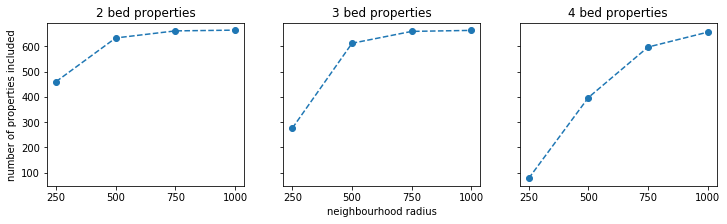

In [65]:
fig = plt.figure(figsize=(12, 3))
axs = fig.subplots(1, 3, sharey=True)
datas = [n_areas_included_2bed, n_areas_included_3bed, n_areas_included_4bed]
titles = ['2 bed properties', '3 bed properties', '4 bed properties']
axs[0].set_ylabel('number of properties included')
axs[1].set_xlabel('neighbourhood radius')
for ax, data, title in zip(axs, datas, titles):
    ax.plot(radii, data, '--o')
    ax.set_title(title)
    ax.set_xticks(radii)

With ``radius`` of 500, almost all neighbourhoods have sufficient properties for the mean price to be computed when 2 or 3 bed properties are considered. There are far fewer 4 bed properties sold each year and even with ``radius`` of 750 many of the neigbhourhoods do not have sufficient data.

From this we can conlude that optimal values for ``radius`` are ``500`` and ``750``. **We will use ``radius`` of ``750``** to maximise the amount of information captured in features for each neighbourhood at the expense of some loss of spatial accuracy.

In [66]:
RADIUS = 750

### Normalizing distributions<a name="analysis.normalizing_distributions"/>

To make sure any classification or ranking algorithm is not biased by any features unintentionally, let's investigate the distribution of values for these features across neighbourhoods. Let's focus on 2 bedroom properties as these are the most commonly sold ones.

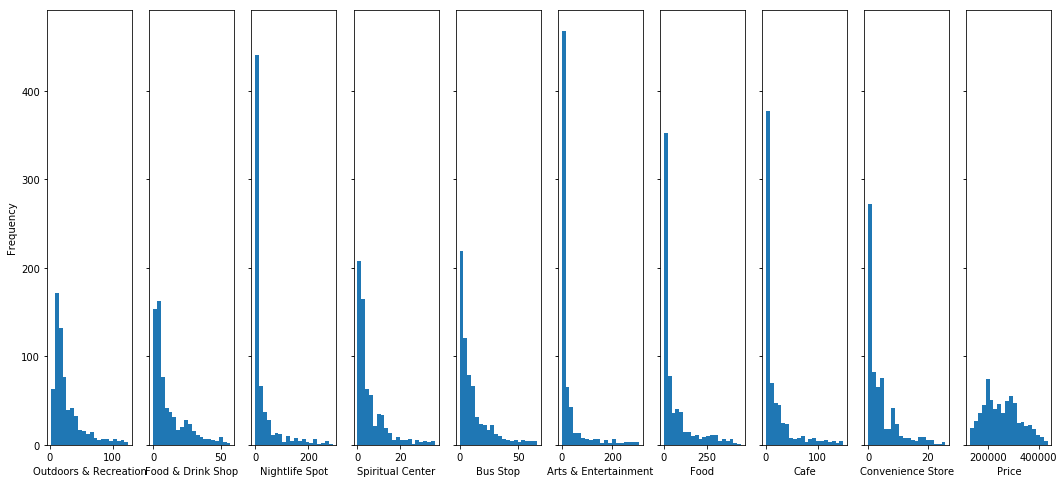

In [100]:
df_features_venues = number_of_venues_in_all_areas(RADIUS, df_venues, df_venue_distances, df_neighbourhoods)
prices = mean_price_in_all_areas(RADIUS, df_property, df_property_distances, 
                                 df_neighbourhoods, bedrooms=[2], min_count=5)
df_features_prices = pd.DataFrame({'Price': prices})
df_features_all = df_features_venues.join(df_features_prices)
plot_multiple_histograms(df_features_all)

The distributions for all features but the *Price* are highly skewed towards low values. This would make clustering with k-means difficult, as the neighourhoods with higher values in any category will be much more separated in the feature space. To account for this, we will use logarithmic values for all features apart from *Price* with the function ``lambda x: np.log(x + 1)``.

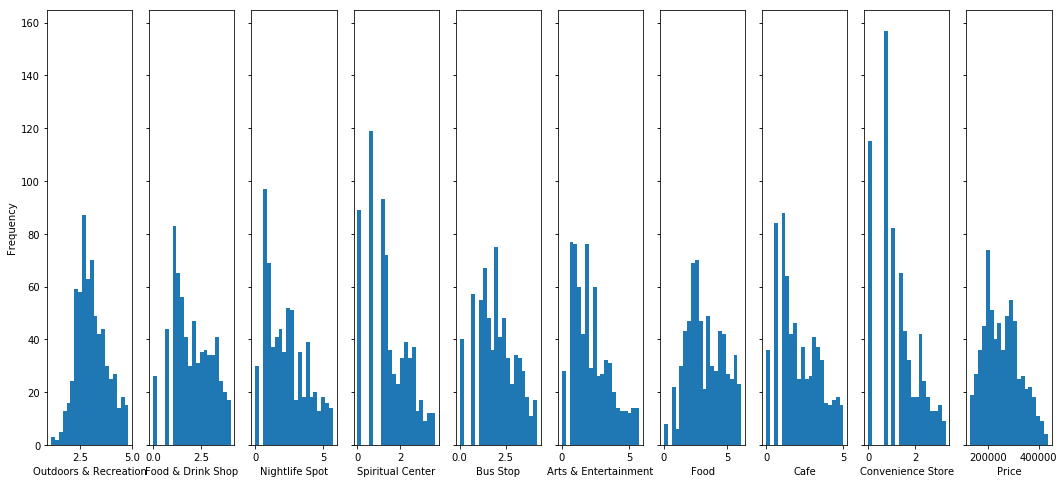

In [101]:
df_features_venues = normalize(df_features_venues, method='log')
df_features_all = df_features_venues.join(df_features_prices)
plot_multiple_histograms(df_features_all)

This will likely be handled much better by k-means clustering. The remaining issue is the large difference in absolute values in the features, particluarly the *Price* category. This would result clustering being based mostly on *Price*. To avoid that, we will use z-score method to normalize each feature.

Furthermore, by normalizing the features, it is then possible introduce intentional bias of certain features, particularly for the ranking system.

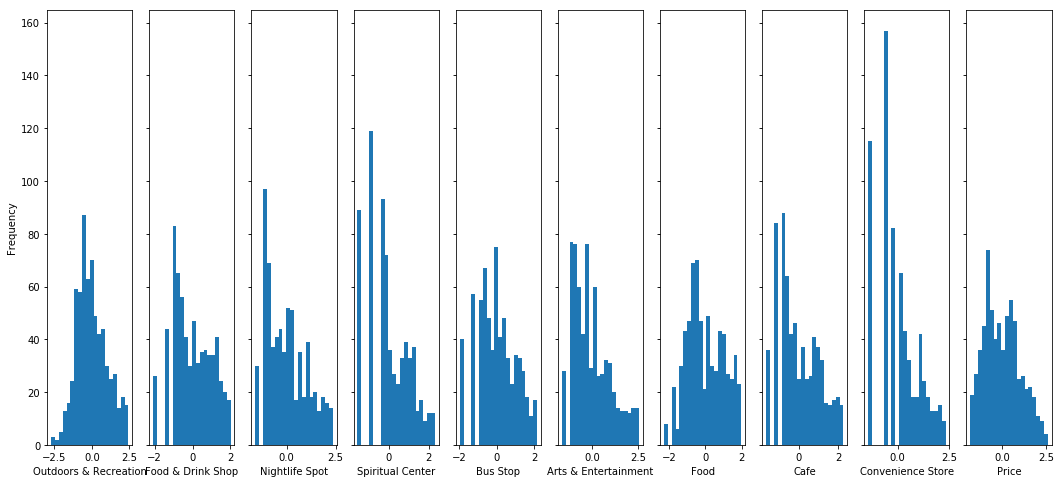

In [102]:
df_features_venues = normalize(df_features_venues, method='zscore')
df_features_prices = normalize(df_features_prices, method='zscore')
df_features_all = df_features_venues.join(df_features_prices)
plot_multiple_histograms(df_features_all)

### Static classification system <a name="analysis.static_classification_system"/>

To decide on the **k-value** (``n_clusters``) to use for clustering, we will use the Average Silhouette Method. We will also inspect the corresponding real mean values of each feature in the resulting clusters and their spatial distribution, to see which clusters are most intuitive. The final ``n_clusters`` and clusters will be chosen by taking all this information into account.

In [154]:
from sklearn.cluster import k_means
from sklearn.metrics import silhouette_score


# Find labels for all neighbourhoods with different values of n_clusters and store inertias
n_cluster_options = list(range(2, 10))
labels = {}
inertias = {}
for n_clusters in n_cluster_options:
    _, labels[n_clusters], inertias[n_clusters] = k_means(df_features_venues.values, 
                                                          n_clusters=n_clusters, random_state=10)
df_neighbourhoods_labels = pd.DataFrame(labels, columns=n_cluster_options)

Display the Inertia and Average Silhoutte Scores for all ``n_clusters`` values.

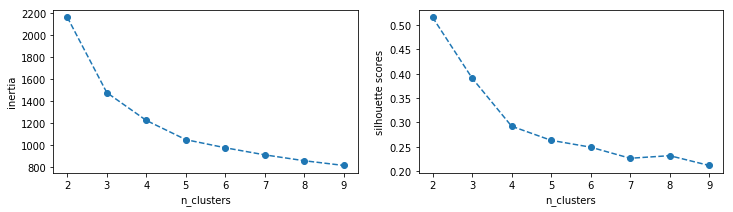

In [155]:
# Calculate Average Silhouette Scores for different values of n_clusters
scores = []
for n_clusters in n_cluster_options:
    scores.append(silhouette_score(df_features_venues.values, df_neighbourhoods_labels[n_clusters]))

# Display Inertia and Average Silhouette Scores for different values of n_clusters
fig = plt.figure(figsize=(12, 3))
axs = fig.subplots(1, 2)
axs[0].set_ylabel('inertia')
axs[1].set_ylabel('silhouette scores')
for ax in axs:
    ax.set_xlabel('n_clusters')
axs[0].plot(n_cluster_options, [inertias[n_clusters] for n_clusters in n_cluster_options], '--o')
axs[1].plot(n_cluster_options, scores, '--o')

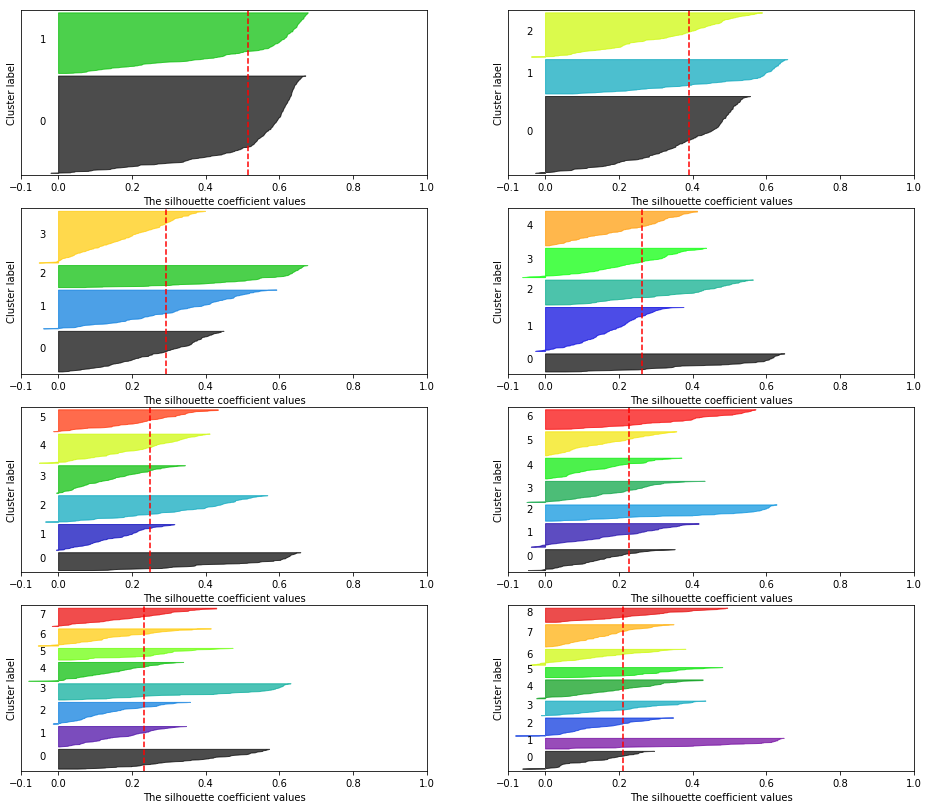

In [161]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples


fig = plt.figure(figsize=(16, 14))
tmp = fig.subplots(4, 2)
axs = []
for axss in tmp:
    axs += list(axss)

for n_clusters, ax in zip(n_cluster_options, axs):
    # The 1st subplot is the silhouette plot
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, df_features_venues.shape[0] + (n_clusters + 1) * 10])
    
    # Compute the average silhouette score
    silhouette_avg = silhouette_score(df_features_venues.values, 
                                      df_neighbourhoods_labels[n_clusters])

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_features_venues.values, 
                                                  df_neighbourhoods_labels[n_clusters])

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[df_neighbourhoods_labels[n_clusters] == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
